总体来看，LeNet（LeNet-5）由两个部分组成：

卷积编码器：由两个卷积层组成;
全连接层密集块：由三个全连接层组成。
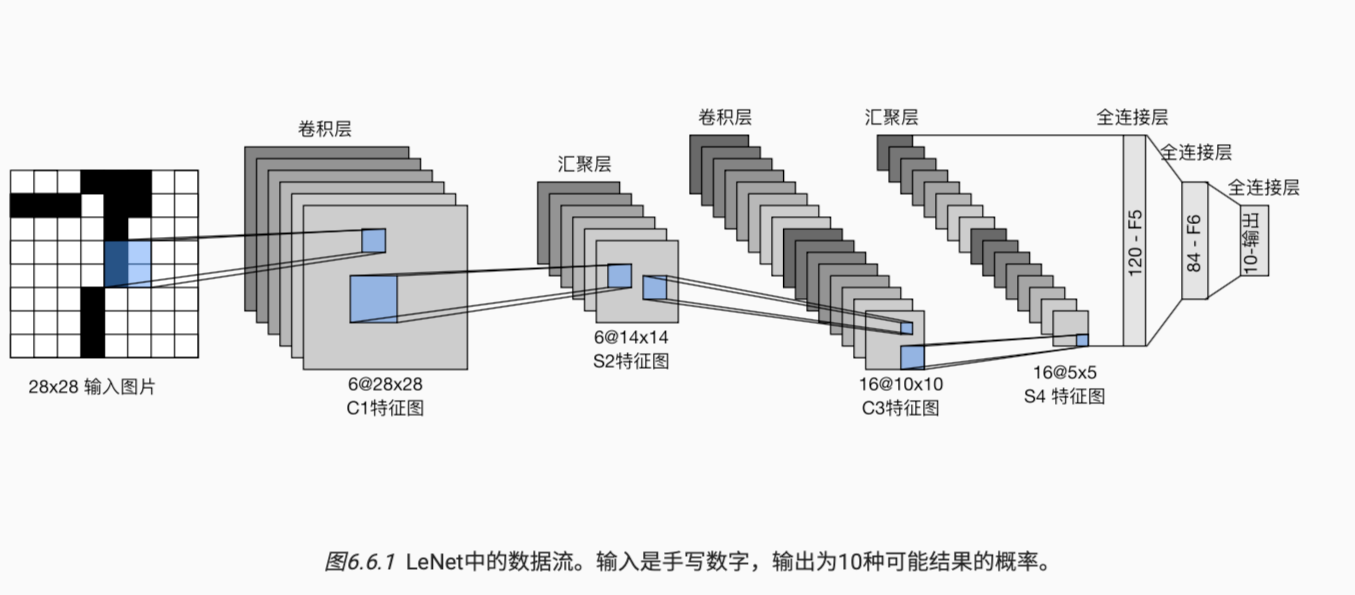
- LeNet是早期成功的神经网络
- 输入的就是28 * 28的单通道黑白图像
- 先使用卷积层来学习图片空间信息
- 然后使用全连接层来转换到类别空间


实现起来也很简单，只需要实例化一个sequential块，并将需要的层连接在一起。

-  nn.Conv2d的格式   
nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')

- nn.Flatten()   
nn.Flatten() 会将 (batch_size, 16, 5, 5) 的输入张量展平为 (batch_size, 16 * 5 * 5) 的一维张量。
它将 (batch_size, channels, height, width) 的多维特征图转换为 (batch_size, channels * height * width) 的一维向量。
这样做的目的是将卷积层和池化层提取的空间特征转换为一个长向量，以便输入到全连接层进行分类或回归等任务。

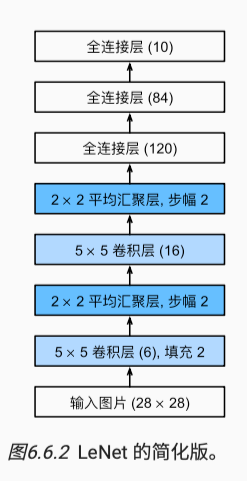

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(), # Flatten:将输出的多维特征图转换为一维向量，使得特征能够被全连接层处理
    nn.Linear(16*5*5,120),nn.Sigmoid(), #5是计算出来的
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
# 查看每个层的形状
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'putput shape: \t',X.shape)

Conv2d putput shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid putput shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d putput shape: 	 torch.Size([1, 6, 14, 14])
Conv2d putput shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid putput shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d putput shape: 	 torch.Size([1, 16, 5, 5])
Flatten putput shape: 	 torch.Size([1, 400])
Linear putput shape: 	 torch.Size([1, 120])
Sigmoid putput shape: 	 torch.Size([1, 120])
Linear putput shape: 	 torch.Size([1, 84])
Sigmoid putput shape: 	 torch.Size([1, 84])
Linear putput shape: 	 torch.Size([1, 10])


In [2]:
# 模型训练
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [3]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [4]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device=torch.device('cpu')):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)  #使用 Xavier 均匀分布初始化 m.weight
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i , (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat,y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

            

loss 0.463, train acc 0.825, test acc 0.782
7649.2 examples/sec on cpu


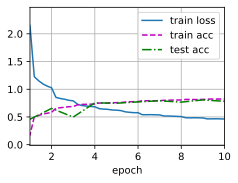

In [5]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr)